# Vision Transformer (ViT)

inspired by this [notebook](https://www.kaggle.com/raufmomin/vision-transformer-vit-fine-tuning)

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import sys, os
from pathlib import Path

import tensorflow as tf
import tensorflow_addons as tfa
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, TerminateOnNaN, EarlyStopping

from tensorflow.keras.utils import Sequence
from collections import Counter
from sklearn.utils.class_weight import compute_class_weight

from vit_keras import vit, utils
from vit_keras import visualize

from keras.models import load_model
from sklearn.metrics import classification_report, confusion_matrix

# sys.path.append('../')
import leukopy_lib as leuko
from importlib import reload

reload(leuko)

from datetime import datetime

In [3]:
t = datetime.now().strftime("%d%m%Y_%H")

OUTPUT_PATH = Path(f'../working/model_save/vit_b32/{t}')
OUTPUT_PATH.mkdir(parents=True, exist_ok=True)

# Set up

## Generate dataframes

In [4]:
# pa/kaggle/ = Path('main_dataset/')
INPUT_PATH = Path('../input/main-dataset/main_dataset/')

df_train = leuko.generate_images_df(INPUT_PATH/'training_set')
df_test = leuko.generate_images_df(INPUT_PATH/'testing_set')
df_valid = leuko.generate_images_df(INPUT_PATH/'validation_set')

df_train.head()

,img_path,cell_type,label,label_2,label_3
0,../input/main-dataset/main_dataset/training_se...,training_set,BA,BA,BA
1,../input/main-dataset/main_dataset/training_se...,training_set,BNE,IG,BNE
2,../input/main-dataset/main_dataset/training_se...,training_set,MO,MO,MO
3,../input/main-dataset/main_dataset/training_se...,training_set,MY,IG,IG
4,../input/main-dataset/main_dataset/training_se...,training_set,BA,BA,BA


### choose classes

In [5]:
N_CLASSES, df_train, df_test, df_valid = leuko.choose_classes(df_train, df_test, df_valid, n_classes = 11)

In [6]:
N_CLASSES

11

In [7]:
df_train["label"].value_counts()

EO     2349
PLT    1739
SNE    1263
BNE    1212
ERB    1162
MO     1068
LY      944
BA      903
MY      833
MMY     734
PMY     460
Name: label, dtype: int64

## Image generator

For ViT image are patched into [16x16](https://arxiv.org/abs/2010.11929) images ("images is worth 16x16 words")

In [8]:
BATCH_SIZE = 32
IMG_SIZE  = 352 #need to be a multiple of patch size = 16
EPOCHS = 100
LR = 1e-3

In [9]:
train_generator = ImageDataGenerator(rotation_range = 90,
                                     horizontal_flip = True, 
                                     vertical_flip = True)
valid_generator = ImageDataGenerator()
test_generator = ImageDataGenerator()

# Resize pictures, batchs from dataframe
training_set = train_generator.flow_from_dataframe(df_train, 
                                                   directory = None, # uses x_col
                                                   x_col = 'img_path', 
                                                   y_col = 'label',
                                                   target_size = (IMG_SIZE, IMG_SIZE), 
                                                   color_mode = 'rgb',
                                                   classes = None,   # uses y_col
                                                   class_mode = 'categorical', 
                                                   batch_size = BATCH_SIZE,
                                                   shuffle = True)

validation_set = valid_generator.flow_from_dataframe(df_valid, 
                                                     directory = None, # uses x_col
                                                     x_col = 'img_path', 
                                                     y_col = 'label',
                                                     target_size = (IMG_SIZE, IMG_SIZE), 
                                                     color_mode = 'rgb',
                                                     classes = None,   # uses y_col
                                                     class_mode = 'categorical', 
                                                     batch_size = BATCH_SIZE, 
                                                     shuffle = True)

testing_set = test_generator.flow_from_dataframe(df_test, 
                                                 directory = None, # uses x_col
                                                 x_col = 'img_path', 
                                                 y_col = 'label',
                                                 target_size = (IMG_SIZE, IMG_SIZE),
                                                 color_mode = 'rgb',
                                                 classes = None,   # uses y_col
                                                 class_mode = 'categorical', 
                                                 batch_size = BATCH_SIZE, 
                                                 shuffle = False)

# Labels/Index connection :
label_map = training_set.class_indices
print('Train :', training_set.class_indices)
print('Valid :', validation_set.class_indices)
print('Test  :', testing_set.class_indices)

Found 12667 validated image filenames belonging to 11 classes.
Found 1730 validated image filenames belonging to 11 classes.
Found 2544 validated image filenames belonging to 11 classes.
Train : {'BA': 0, 'BNE': 1, 'EO': 2, 'ERB': 3, 'LY': 4, 'MMY': 5, 'MO': 6, 'MY': 7, 'PLT': 8, 'PMY': 9, 'SNE': 10}
Valid : {'BA': 0, 'BNE': 1, 'EO': 2, 'ERB': 3, 'LY': 4, 'MMY': 5, 'MO': 6, 'MY': 7, 'PLT': 8, 'PMY': 9, 'SNE': 10}
Test  : {'BA': 0, 'BNE': 1, 'EO': 2, 'ERB': 3, 'LY': 4, 'MMY': 5, 'MO': 6, 'MY': 7, 'PLT': 8, 'PMY': 9, 'SNE': 10}


### Visualise images and attention

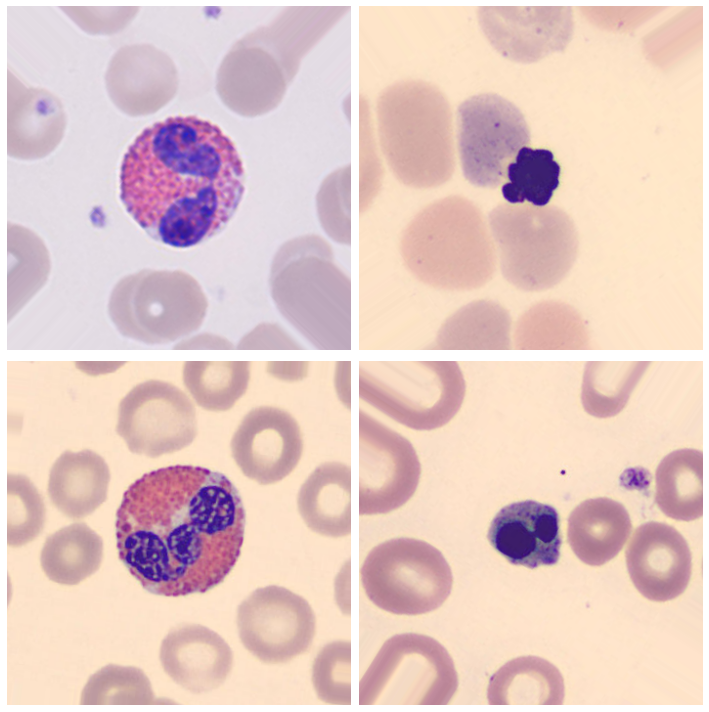

In [10]:
images = [training_set[0][0][i] for i in range(5)]
fig, axes = plt.subplots(2, 2, figsize = (10, 10))

axes = axes.flatten()

for img, ax in zip(images, axes):
    ax.imshow(img.reshape(IMG_SIZE, IMG_SIZE, 3).astype('uint8'))
    ax.axis('off')

plt.tight_layout()
plt.show()

## ViT model set up

In [11]:
# classes = utils.get_imagenet_classes()

vit_model = vit.vit_b32(
    weights='imagenet21k+imagenet2012',
        image_size = IMG_SIZE,
        activation = 'softmax',
        pretrained = True,
        include_top = False,
        pretrained_top = False, #fine tune
        classes = N_CLASSES)


353255424/353253686 [==============================] - 4s 0us/step


/opt/conda/lib/python3.7/site-packages/vit_keras/utils.py:83: UserWarning: Resizing position embeddings from 12, 12 to 11, 11
  UserWarning,


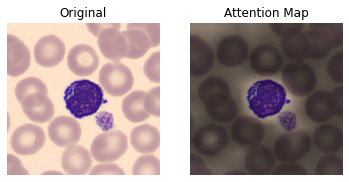

In [12]:
x = testing_set.next()
image = x[0][0]

attention_map = visualize.attention_map(model = vit_model, image = image)

# Plot results
fig, (ax1, ax2) = plt.subplots(ncols = 2)
ax1.axis('off')
ax2.axis('off')
ax1.set_title('Original')
ax2.set_title('Attention Map')
_ = ax1.imshow(image.astype('uint8'))
_ = ax2.imshow(attention_map)

In [13]:
# vit_model.trainable = False

# for layer in vit_model.layers[-16:]:
#     layer.trainable = True
#     print(layer, layer.trainable)
    
# vit_model.summary()

In [14]:
model = tf.keras.Sequential([
        vit_model,
#         tf.keras.layers.BatchNormalization(),
#         tf.keras.layers.Dense(256, activation = tfa.activations.gelu),
#         tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dense(11, 'softmax')
    ],
    name = 'vision_transformer')

model.summary()

Model: "vision_transformer"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vit-b32 (Functional)         (None, 768)               87510528  
_________________________________________________________________
dense (Dense)                (None, 11)                8459      
Total params: 87,518,987
Trainable params: 87,518,987
Non-trainable params: 0
_________________________________________________________________


In [15]:
# model.layers[0].trainable = False

# for layer in model.layers:
#     print(layer, layer.trainable)
    
# model.summary()


In [16]:
f1_metric = tfa.metrics.F1Score(num_classes=11, average='macro', name='f1')
precision = tf.keras.metrics.Precision(name='precision')
recall = tf.keras.metrics.Recall(name='recall')

In [17]:
optimizer = tfa.optimizers.RectifiedAdam(learning_rate = LR)

model.compile(optimizer = optimizer, 
              loss = tf.keras.losses.CategoricalCrossentropy(label_smoothing = 0.05),
              metrics = ['accuracy', f1_metric, precision, recall])

In [18]:
# Callbacks


reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor = 'val_accuracy',
                                                 factor = 0.2,
                                                 patience = 2,
                                                 verbose = 1,
                                                 min_delta = 1e-4,
                                                 min_lr = 1e-6,
                                                 mode = 'max')

earlystopping = tf.keras.callbacks.EarlyStopping(monitor = 'val_accuracy',
                                                 min_delta = 1e-4,
                                                 patience = 5,
                                                 mode = 'max',
                                                 restore_best_weights = True,
                                                 verbose = 1)

checkpointer = tf.keras.callbacks.ModelCheckpoint(filepath = OUTPUT_PATH/'model.hdf5',
                                                  monitor = 'val_accuracy', 
                                                  verbose = 1, 
                                                  save_best_only = True,
                                                  save_weights_only = True,
                                                  mode = 'max')

log_dir = OUTPUT_PATH/'logs'
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)


callbacks_list = [earlystopping, reduce_lr, checkpointer, tensorboard_callback]

In [19]:

## Compute weights :
# class_weights = compute_weights(method = 3)

## Training :
epochs = 100
training_history = model.fit(x = training_set, 
                             steps_per_epoch = training_set.n/training_set.batch_size,
                             validation_steps = validation_set.n/validation_set.batch_size,

                             epochs = epochs,
                             callbacks = callbacks_list,
                             validation_data = validation_set, 
#                              class_weight = class_weights
                            )

model.save(OUTPUT_PATH)

Epoch 1/100
395/395 [==============================] - 553s 1s/step - loss: 2.0537 - accuracy: 0.3205 - f1: 0.2419 - precision: 0.6576 - recall: 0.1351 - val_loss: 1.2617 - val_accuracy: 0.5884 - val_f1: 0.4846 - val_precision: 0.7401 - val_recall: 0.4659

Epoch 00001: val_accuracy improved from -inf to 0.58844, saving model to ../working/model_save/vit_b32/22092021_08/model.hdf5
Epoch 2/100
395/395 [==============================] - 449s 1s/step - loss: 1.0903 - accuracy: 0.6628 - f1: 0.5812 - precision: 0.8250 - recall: 0.5337 - val_loss: 0.9957 - val_accuracy: 0.6988 - val_f1: 0.6337 - val_precision: 0.7819 - val_recall: 0.6133

Epoch 00002: val_accuracy improved from 0.58844 to 0.69884, saving model to ../working/model_save/vit_b32/22092021_08/model.hdf5
Epoch 3/100
395/395 [==============================] - 449s 1s/step - loss: 0.9428 - accuracy: 0.7158 - f1: 0.6414 - precision: 0.8398 - recall: 0.6112 - val_loss: 0.8543 - val_accuracy: 0.7549 - val_f1: 0.6644 - val_precision: 0.8

In [20]:
import pickle

with open(OUTPUT_PATH/'training_hist', 'wb') as f:
    pickle.dump(training_history.history, f)

In [21]:
model.save(OUTPUT_PATH/'model_vit_test')


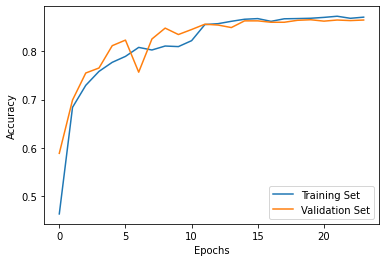

In [22]:
training_accuracy = training_history.history['accuracy']
validation_accuracy = training_history.history['val_accuracy']

plt.figure()
plt.plot(np.arange(earlystopping.stopped_epoch), training_accuracy[0:earlystopping.stopped_epoch], label = 'Training Set')
plt.plot(np.arange(earlystopping.stopped_epoch), validation_accuracy[0:earlystopping.stopped_epoch], label = 'Validation Set')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [23]:
model.evaluate(testing_set)


80/80 [==============================] - 29s 368ms/step - loss: 0.5912 - accuracy: 0.8644 - f1: 0.8330 - precision: 0.8897 - recall: 0.8337


[0.5912317633628845,
 0.864386796951294,
 0.8330157995223999,
 0.8896812200546265,
 0.8337264060974121]

In [24]:
model.evaluate(validation_set)

55/55 [==============================] - 13s 225ms/step - loss: 0.5886 - accuracy: 0.8653 - f1: 0.8337 - precision: 0.8921 - recall: 0.8364


[0.5885550379753113,
 0.8653179407119751,
 0.8336565494537354,
 0.8921085000038147,
 0.8364161849021912]

In [25]:
predicted_classes = np.argmax(model.predict(valid_gen, steps = valid_gen.n // valid_gen.batch_size + 1), axis = 1)
true_classes = valid_gen.classes
class_labels = list(valid_gen.class_indices.keys())  

confusionmatrix = confusion_matrix(true_classes, predicted_classes)
plt.figure(figsize = (16, 16))
sns.heatmap(confusionmatrix, cmap = 'Blues', annot = True, cbar = True)

print(classification_report(true_classes, predicted_classes))

NameError: name 'valid_gen' is not defined

In [ ]:
predictions = model.predict(validation_set)
y_pred = tf.argmax(predictions, axis = 1)

In [ ]:
predicted_classes = np.argmax(model.predict(validation_set,
                                            steps = validation_set.n // validation_set.batch_size + 1), 
                              axis = 1)

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix

confusion_matrix(validation_set.classes, y_pred)

In [ ]:
import seaborn as sns
# true_classes = validation_set.classes
# class_labels = list(validation_set.class_indices.keys())  

# confusionmatrix = confusion_matrix(true_classes, predicted_classes)
plt.figure(figsize = (5, 5))
sns.heatmap(confusion_matrix(validation_set.classes, y_pred), cmap = 'Blues', annot = True, cbar = True)

# print(classification_report(true_classes, predicted_classespredictions

In [ ]:
training_accuracy = training_history.history['accuracy']
validation_accuracy = training_history.history['val_accuracy']

plt.figure()
plt.plot(np.arange(early_stopping.stopped_epoch), training_accuracy[0:early_stopping.stopped_epoch], label = 'Training Set')
plt.plot(np.arange(early_stopping.stopped_epoch), validation_accuracy[0:early_stopping.stopped_epoch], label = 'Validation Set')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()